In [1]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
#pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Capstone NCAA Project

Mounted at /content/drive
/content/drive/MyDrive/Capstone NCAA Project


## Data Preparation

### Seeds

In [3]:
df_seeds = pd.read_csv("data/2022_Stage1/MNCAATourneySeeds.csv")
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


### Season Results

In [4]:
df_season_results = pd.read_csv("data/2022_Stage1/MRegularSeasonCompactResults.csv")
df_season_results.drop(['WLoc', 'NumOT'], axis=1, inplace=True)

In [5]:
df_season_results['ScoreDiff'] = df_season_results['WScore'] - df_season_results['LScore']

In [6]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreDiff
0,1985,20,1228,81,1328,64,17
1,1985,25,1106,77,1354,70,7
2,1985,25,1112,63,1223,56,7
3,1985,25,1165,70,1432,54,16
4,1985,25,1192,86,1447,74,12


#### Features

For each team for each season, we need to compute:

<li>Number of wins</li>
<li>Number of losses</li>
<li>Average score gap of wins</li>
<li>Average score gap of losses</li>

In order to calculate the following features: 
<li>Win Percentage</li>
<li>Average margin of victory/loss</li>


In [7]:
win_count = df_season_results.groupby(['Season', 'WTeamID']).count()
win_count = win_count.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "WinCount", "WTeamID": "TeamID"})
win_count

,Season,TeamID,WinCount
0,1985,1102,5
1,1985,1103,9
2,1985,1104,21
3,1985,1106,10
4,1985,1108,19
...,...,...,...
12276,2022,1468,9
12277,2022,1469,7
12278,2022,1470,8
12279,2022,1471,8


In [8]:
loss_count = df_season_results.groupby(['Season', 'LTeamID']).count()
loss_count = loss_count.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "LossCount", "LTeamID": "TeamID"})
loss_count

,Season,TeamID,LossCount
0,1985,1102,19
1,1985,1103,14
2,1985,1104,9
3,1985,1106,14
4,1985,1108,6
...,...,...,...
12290,2022,1468,11
12291,2022,1469,12
12292,2022,1470,13
12293,2022,1471,12


In [9]:
win_margin = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
win_margin = win_margin[['Season', 'WTeamID', 'ScoreDiff']].rename(columns={"ScoreDiff": "AverageWinMargin", "WTeamID": "TeamID"})
win_margin

,Season,TeamID,AverageWinMargin
0,1985,1102,10.000000
1,1985,1103,7.555556
2,1985,1104,13.190476
3,1985,1106,9.500000
4,1985,1108,13.842105
...,...,...,...
12276,2022,1468,10.666667
12277,2022,1469,11.428571
12278,2022,1470,11.125000
12279,2022,1471,10.125000


In [10]:
loss_margin = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
loss_margin = loss_margin[['Season', 'LTeamID', 'ScoreDiff']].rename(columns={"ScoreDiff": "AverageLossMargin", "LTeamID": "TeamID"})
loss_margin

,Season,TeamID,AverageLossMargin
0,1985,1102,9.947368
1,1985,1103,9.857143
2,1985,1104,4.777778
3,1985,1106,13.285714
4,1985,1108,10.666667
...,...,...,...
12290,2022,1468,16.545455
12291,2022,1469,19.333333
12292,2022,1470,11.769231
12293,2022,1471,13.416667


In [11]:
df_features_season_wins = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_wins

,Season,TeamID
0,1985,1102
1,1985,1103
2,1985,1104
3,1985,1106
4,1985,1108
...,...,...
12276,2022,1468
12277,2022,1469
12278,2022,1470
12279,2022,1471


In [12]:
df_features_season_losses = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})
df_features_season_losses

,Season,TeamID
0,1985,1102
1,1985,1103
2,1985,1104
3,1985,1106
4,1985,1108
...,...,...
12290,2022,1468
12291,2022,1469
12292,2022,1470
12293,2022,1471


In [13]:
df_features_season = pd.concat([df_features_season_wins, df_features_season_losses], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [14]:
df_features_season = df_features_season.merge(win_count, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(loss_count, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(win_margin, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(loss_margin, on=['Season', 'TeamID'], how='left')
df_features_season.fillna(0, inplace=True)  
df_features_season

,Season,TeamID,WinCount,LossCount,AverageWinMargin,AverageLossMargin
0,1985,1102,5.0,19.0,10.000000,9.947368
1,1985,1103,9.0,14.0,7.555556,9.857143
2,1985,1104,21.0,9.0,13.190476,4.777778
3,1985,1106,10.0,14.0,9.500000,13.285714
4,1985,1108,19.0,6.0,13.842105,10.666667
...,...,...,...,...,...,...
12294,2022,1468,9.0,11.0,10.666667,16.545455
12295,2022,1469,7.0,12.0,11.428571,19.333333
12296,2022,1470,8.0,13.0,11.125000,11.769231
12297,2022,1471,8.0,12.0,10.125000,13.416667


In [15]:
df_features_season['WinPercentage'] = df_features_season['WinCount'] / (df_features_season['WinCount'] + df_features_season['LossCount'])
df_features_season['GapAvg'] = (
    (df_features_season['WinCount'] * df_features_season['AverageWinMargin'] - 
    df_features_season['LossCount'] * df_features_season['AverageLossMargin'])
    / (df_features_season['WinCount'] + df_features_season['LossCount'])
)

In [16]:
df_features_season.drop(['WinCount', 'LossCount', 'AverageWinMargin', 'AverageLossMargin'], axis=1, inplace=True)

In [17]:
df_tourney_results = pd.read_csv("data/2022_Stage1/MNCAATourneyCompactResults.csv")
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [18]:
df_538 = pd.read_csv("data/538ratingsMen.csv")
df_538.drop('TeamName', axis=1, inplace=True)
df_538

,Season,TeamID,538rating
0,2016,1242,94.46
1,2016,1314,93.94
2,2016,1438,92.46
3,2016,1277,91.84
4,2016,1328,89.96
...,...,...,...
403,2022,1168,71.78
404,2022,1136,71.55
405,2022,1313,71.39
406,2022,1411,71.14


## Feature Engineering

### Training data

In [19]:
df = df_tourney_results.copy()
df = df[df['Season'] >= 2016].reset_index(drop=True)
df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2016,134,1195,96,1192,65
1,2016,134,1455,70,1435,50
2,2016,135,1221,59,1380,55
3,2016,135,1276,67,1409,62
4,2016,136,1114,85,1345,83
...,...,...,...,...,...,...
329,2021,148,1211,85,1425,66
330,2021,148,1417,51,1276,49
331,2021,152,1124,78,1222,59
332,2021,152,1211,93,1417,90


In [20]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [21]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [22]:
#Remove region and play in tournament marker from seed
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [23]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [24]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2016,134,1195,96,1192,65,16,16
1,2016,134,1455,70,1435,50,11,11
2,2016,135,1221,59,1380,55,16,16
3,2016,135,1276,67,1409,62,11,11
4,2016,136,1114,85,1345,83,12,5


In [25]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinCount': 'WinCountW',
    'LossCount': 'LossCountW',
    'AverageWinMargin': 'AverageWinMarginW',
    'AverageLossMargin': 'AverageLossMarginW',
    'WinPercentage': 'WinPercentageW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)


In [26]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinCount': 'WinCountL',
    'LossCount': 'LossCountL',
    'AverageWinMargin': 'AverageWinMarginL',
    'AverageLossMargin': 'AverageLossMarginL',
    'WinPercentage': 'WinPercentageL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)


In [27]:
df.head()


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,WinPercentageW,GapAvgW,WinPercentageL,GapAvgL
0,2016,134,1195,96,1192,65,16,16,0.551724,2.724138,0.548387,-1.677419
1,2016,134,1455,70,1435,50,11,11,0.741935,13.709677,0.593750,9.406250
2,2016,135,1221,59,1380,55,16,16,0.424242,-4.333333,0.612903,1.870968
3,2016,135,1276,67,1409,62,11,11,0.636364,6.242424,0.645161,4.322581
4,2016,136,1114,85,1345,83,12,5,0.870968,9.935484,0.764706,13.147059


In [28]:
df = pd.merge(
    df,
    df_538,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingW'})


In [29]:
df = pd.merge(
    df, 
    df_538, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingL'})


In [30]:
df.head()


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,WinPercentageW,GapAvgW,WinPercentageL,GapAvgL,538ratingW,538ratingL
0,2016,134,1195,96,1192,65,16,16,0.551724,2.724138,0.548387,-1.677419,71.41,66.72
1,2016,134,1455,70,1435,50,11,11,0.741935,13.709677,0.593750,9.406250,86.59,85.59
2,2016,135,1221,59,1380,55,16,16,0.424242,-4.333333,0.612903,1.870968,66.85,67.96
3,2016,135,1276,67,1409,62,11,11,0.636364,6.242424,0.645161,4.322581,79.57,79.93
4,2016,136,1114,85,1345,83,12,5,0.870968,9.935484,0.764706,13.147059,78.90,88.68


In [31]:
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})
    
    win_df = df.copy()
    lose_df = df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], axis=0, sort=False)


In [32]:
df = add_loosing_matches(df)

In [33]:
df.head()


,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinPercentageA,GapAvgA,WinPercentageB,GapAvgB,538ratingA,538ratingB
0,2016,134,1195,96,1192,65,16,16,0.551724,2.724138,0.548387,-1.677419,71.41,66.72
1,2016,134,1455,70,1435,50,11,11,0.741935,13.709677,0.593750,9.406250,86.59,85.59
2,2016,135,1221,59,1380,55,16,16,0.424242,-4.333333,0.612903,1.870968,66.85,67.96
3,2016,135,1276,67,1409,62,11,11,0.636364,6.242424,0.645161,4.322581,79.57,79.93
4,2016,136,1114,85,1345,83,12,5,0.870968,9.935484,0.764706,13.147059,78.90,88.68


####Feature Differences

In [34]:
cols_to_diff = ['Seed', 'WinPercentage', 'GapAvg', '538rating']

for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

In [35]:
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinPercentageA,GapAvgA,WinPercentageB,GapAvgB,538ratingA,538ratingB,SeedDiff,WinPercentageDiff,GapAvgDiff,538ratingDiff
0,2016,134,1195,96,1192,65,16,16,0.551724,2.724138,0.548387,-1.677419,71.41,66.72,0,0.003337,4.401557,4.69
1,2016,134,1455,70,1435,50,11,11,0.741935,13.709677,0.593750,9.406250,86.59,85.59,0,0.148185,4.303427,1.00
2,2016,135,1221,59,1380,55,16,16,0.424242,-4.333333,0.612903,1.870968,66.85,67.96,0,-0.188661,-6.204301,-1.11
3,2016,135,1276,67,1409,62,11,11,0.636364,6.242424,0.645161,4.322581,79.57,79.93,0,-0.008798,1.919844,-0.36
4,2016,136,1114,85,1345,83,12,5,0.870968,9.935484,0.764706,13.147059,78.90,88.68,7,0.106262,-3.211575,-9.78


#### Test Data
##### Preparing

In [36]:
df_test = pd.read_csv("data/2022_Stage1/MSampleSubmissionStage1.csv")

In [37]:
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [38]:
df_test.head()


,ID,Pred,Season,TeamIdA,TeamIdB
0,2016_1112_1114,0.5,2016,1112,1114
1,2016_1112_1122,0.5,2016,1112,1122
2,2016_1112_1124,0.5,2016,1112,1124
3,2016_1112_1138,0.5,2016,1112,1138
4,2016_1112_1139,0.5,2016,1112,1139


##### Seeds

In [39]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})

In [40]:
df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})


In [41]:
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

In [42]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinCount': 'WinCountA',
    'LossCount': 'LossCountA',
    'AverageWinMargin': 'AverageWinMarginA',
    'AverageLossMargin': 'AverageLossMarginA',
    'WinPercentage': 'WinPercentageA',
    'GapAvg': 'GapAvgA',
}).drop(columns='TeamID', axis=1)

In [43]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'WinCount': 'WinCountB',
    'LossCount': 'LossCountB',
    'AverageWinMargin': 'AverageWinMarginB',
    'AverageLossMargin': 'AverageLossMarginB',
    'WinPercentage': 'WinPercentageB',
    'GapAvg': 'GapAvgB',
}).drop(columns='TeamID', axis=1)

In [44]:
df_test = pd.merge(
    df_test,
    df_538,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingA'})

In [45]:
df_test = pd.merge(
    df_test,
    df_538,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingB'})

In [46]:
for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

In [47]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinPercentageA,GapAvgA,WinPercentageB,GapAvgB,538ratingA,538ratingB,SeedDiff,WinPercentageDiff,GapAvgDiff,538ratingDiff
0,2016_1112_1114,0.5,2016,1112,1114,6,12,0.757576,12.212121,0.870968,9.935484,89.04,78.90,-6,-0.113392,2.276637,10.14
1,2016_1112_1122,0.5,2016,1112,1122,6,16,0.757576,12.212121,0.484848,-2.363636,89.04,68.83,-10,0.272727,14.575758,20.21
2,2016_1112_1124,0.5,2016,1112,1124,6,5,0.757576,12.212121,0.656250,6.687500,89.04,85.47,1,0.101326,5.524621,3.57
3,2016_1112_1138,0.5,2016,1112,1138,6,14,0.757576,12.212121,0.575758,0.666667,89.04,75.66,-8,0.181818,11.545455,13.38
4,2016_1112_1139,0.5,2016,1112,1139,6,9,0.757576,12.212121,0.677419,9.419355,89.04,84.17,-3,0.080156,2.792766,4.87


In [48]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

## Modeling

In [49]:
features = ['SeedDiff', '538ratingDiff', 'WinPercentageDiff', 'GapAvgDiff']

In [50]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

In [59]:
from xgboost.sklearn import XGBClassifier
import xgboost

def kfoldxgb(df, df_test_=None, mode='reg', verbose=0):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    if mode == 'reg':
      target = "ScoreDiff"
      model = xgboost.XGBRegressor(objective='reg:squarederror', max_depth=2)
    if mode == 'class':
      target = 'WinA'
      model = xgboost.XGBClassifier(objective='binary:logistic', max_depth=2)
    
    for season in seasons[1:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)

        model.fit(df_train[features], df_train[target])
        
        if mode == 'reg':
          pred = model.predict(df_val[features])
          pred = (pred - pred.min()) / (pred.max() - pred.min())
        if mode == 'class':
          pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
          if mode == 'reg':
            pred_test = model.predict(df_test[features])
            pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())

          if mode == 'class':
            pred_test = model.predict_proba(df_test[features])[:, 1]

          pred_tests.append(pred_test)
        
        np.seterr(invalid='ignore')
        pred = pred.astype(np.float64)
        loss = log_loss(df_val['WinA'].values, pred)
        cvs.append(loss)

        if verbose:
            print(f'\t -> Scored {loss:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    return pred_tests

In [60]:
kfoldxgb(df, df_test, verbose=1)


Validating on season 2017
	 -> Scored 0.576

Validating on season 2018
	 -> Scored 0.593

Validating on season 2019
	 -> Scored 0.515

Validating on season 2021
	 -> Scored 0.598

 Local CV is 0.570


[array([0.6449316 , 0.8269548 , 0.6848211 , ..., 0.65139014, 0.3954932 ,
        0.43585965], dtype=float32),
 array([0.6711558 , 0.7343987 , 0.6524611 , ..., 0.5816728 , 0.42595246,
        0.56488895], dtype=float32),
 array([0.66836286, 0.79226637, 0.62122226, ..., 0.5339065 , 0.36167535,
        0.48742652], dtype=float32),
 array([0.6778784 , 0.8143297 , 0.6444127 , ..., 0.5238996 , 0.33315566,
        0.4108219 ], dtype=float32)]

In [61]:
kfoldxgb(df, df_test, 'class', verbose=1)


Validating on season 2017
	 -> Scored 0.740

Validating on season 2018
	 -> Scored 0.645

Validating on season 2019
	 -> Scored 0.492

Validating on season 2021
	 -> Scored 0.643

 Local CV is 0.630


[array([0.59370786, 0.82983655, 0.96089727, ..., 0.7320903 , 0.12189686,
        0.16648111], dtype=float32),
 array([0.9102317 , 0.93749374, 0.7844087 , ..., 0.6457498 , 0.18516415,
        0.22122525], dtype=float32),
 array([0.8751874 , 0.82871854, 0.8254112 , ..., 0.7205781 , 0.22918326,
        0.26466668], dtype=float32),
 array([0.89018846, 0.92123395, 0.8123116 , ..., 0.6601128 , 0.19378583,
        0.30338475], dtype=float32)]

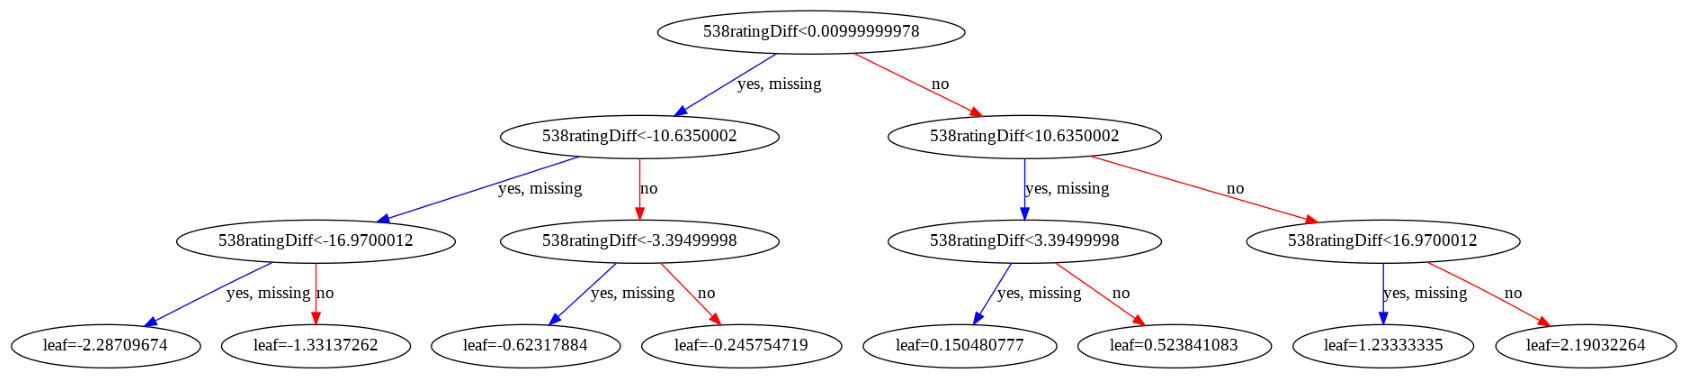

In [66]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
model = xgboost.XGBRegressor(objective='reg:squarederror')
target = "ScoreDiff"
model.fit(df[features], df[target])

plot_tree(model)
fig = plt.gcf()
fig.set_size_inches(30, 20)

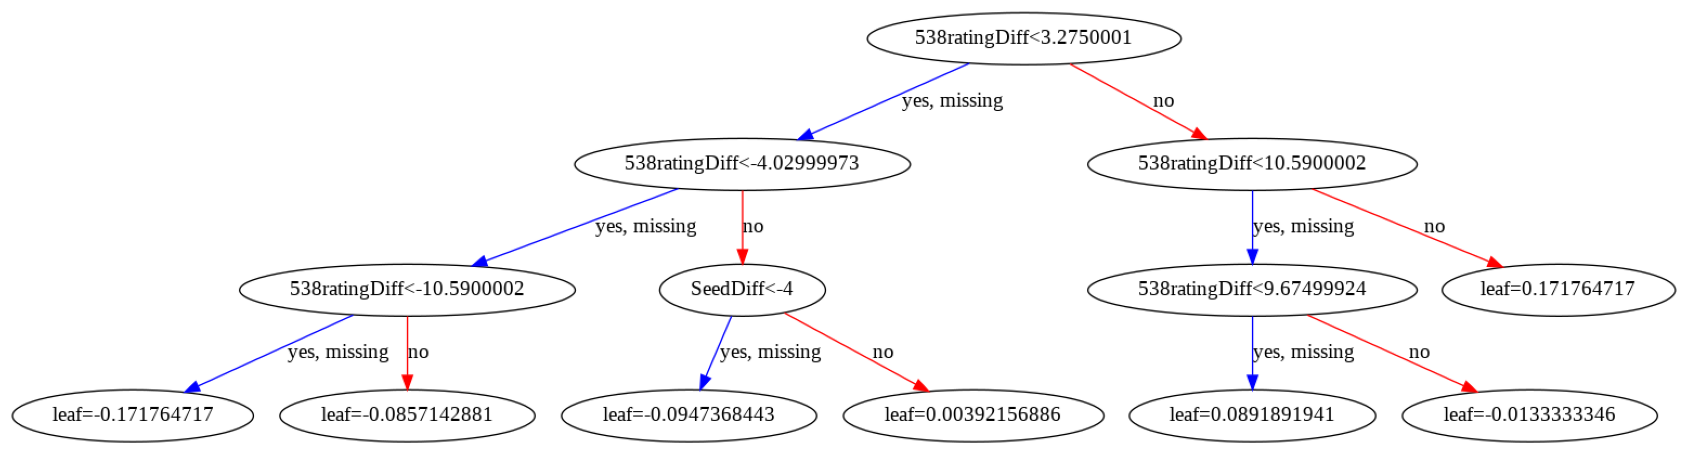

In [58]:
from xgboost import plot_tree
model = xgboost.XGBClassifier(objective='binary:logistic')
target = "WinA"
model.fit(df[features], df[target])

plot_tree(model)
fig = plt.gcf()
fig.set_size_inches(30, 15)